# Table of content
1. [Modules import](#Modules-import)  
2. [Data](#Data)  
    1. [Loading training dataset](#Loading-training-dataset)
    2. [Training set](#Training-set)
    3. [Data cleaning and dimensionality reduction](#Data-cleaning-and-dimensionality-reduction)
3. [Building classifier](#Building-classifier)  
4. [Results](#Results)  
    1. [Laying](#Laying)  
    2. [Sitting](#Sitting)
    3. [Standing](#Standing)
    4. [Walking](#Walking)  
    5. [Walking downstairs](#Walking-downstairs)  
    6. [Walking upstairs](#Walking-upstairs)     
5. [Buisness applications](#Buisness-applications)     
6. [Bibliography](#Bibliography)

## Modules import

In [1]:
import pandas as pd             
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns
from random import shuffle
from plotnine import ggplot, geom_line, aes, stat_smooth, facet_wrap, theme_classic, ggtitle

import shap

from sklearn.model_selection import train_test_split                    
from sklearn.inspection import plot_partial_dependence
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, mutual_info_classif  
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

import xgboost
from xgboost import XGBClassifier

import eli5
from eli5.sklearn import PermutationImportance # obliczanie istotności cech

The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.


# Data
## Loading training dataset 

In [2]:
train_data = pd.read_csv("../.data/final_train.csv")

## Training set
The training dataset consists of 11,087 instances, each one represented by 573 attributes. A goal class is described in the `Activity` variable. There are six, nominal labels:
* LAYING
* SITTING
* STANDING
* WALKING
* WALKING_UPSTAIRS
* WALKING_DOWNSTAIRS

Remaining variables are numeric, each one contains about 50 `NaN` values.

In [3]:
train_data.head()

,Unnamed: 0,Activity,"angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyAccMean,gravity)","angle(tBodyGyroJerkMean,gravityMean)","angle(tBodyGyroMean,gravityMean)",energy-mean(),...,tGravityAccMag-energy(),tGravityAccMag-entropy(),tGravityAccMag-iqr(),tGravityAccMag-mad(),tGravityAccMag-max(),tGravityAccMag-mean(),tGravityAccMag-min(),tGravityAccMag-sma(),tGravityAccMag-std(),void()
0,0,STANDING,-1.574191,-0.805700,-2.453831,-1.861714,0.115517,-2.023369,3.125860,-9.474436,...,5.049130,3.272281,5.103018,-0.823302,3.063681,-0.928676,-1.007695,3.094236,1.669987,1.0
1,1,WALKING_UPSTAIRS,-1.568669,-0.612620,-2.488338,-1.751117,0.218134,0.280294,7.953403,-0.679894,...,4.565443,4.440779,3.288399,-2.689605,1.705341,-0.822617,-0.572410,-2.187890,-0.544652,2.0
2,2,LAYING,-1.548333,-0.139628,-2.380889,-1.915239,0.067613,-0.887342,6.007361,-11.906904,...,5.059609,2.296603,5.344174,-0.549843,3.272225,-0.940610,-1.031522,-2.071755,2.024442,3.0
3,3,WALKING,-1.574094,-0.793443,-2.449959,-1.842741,-0.195625,-0.950671,2.104353,-11.906121,...,4.860758,4.177535,3.950012,-0.322642,2.366287,-0.866937,-0.696431,1.863375,0.550414,2.0
4,4,LAYING,-1.548333,-0.139628,-2.380889,NaN,0.067613,-0.887342,6.007361,-11.970485,...,5.059609,2.296603,5.344174,-0.549843,3.272225,-0.940610,-1.031522,-2.102513,2.024442,3.0


First column (displayed above as `Unnamed: 0`) is an identifier of an instance. Therefore we drop this variable as well as `subject`, which contains identifier of an observed person. Using these variables may lead to model overfitting.

In [4]:
train_data.drop(["Unnamed: 0", "subject"], axis='columns', inplace=True)

All the data was gathered from accelerometer (image on the left-hand side) and gyroscope (image on the right-hand side). Variables describe XYZ axes references and their changes in 2.56 sec windows. Beside raw data recorded by a mobile phone, there are also variables obtained by applying Fast Fourier Transformation (FFT).

<table><tr><td><img title='accelerometer 'src='../images/accelerometer.png'></td><td><img title='gyroscope 'src='../images/gyroscope.png'></td></tr></table>

Phone was fixed to the belt in horizontal orientation. Thus the X-axis is the vertical one.

<div style="text-align: center;">
<img title='pose' src='../images/pose.png'>
</div>

## Data cleaning and dimensionality reduction

To familiarize and deepen the data we use SHAP. We discover that variable `angle(X,gravityMean)` is incredibly important. We visualize it values for each class.

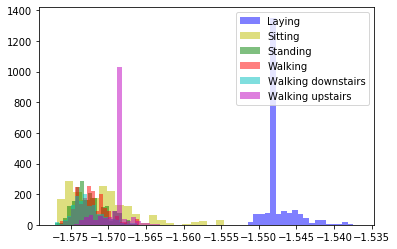

In [5]:
laying = train_data.loc[train_data.Activity == "LAYING", "angle(X,gravityMean)"]
sitting = train_data.loc[train_data.Activity == "SITTING", "angle(X,gravityMean)"]
standing = train_data.loc[train_data.Activity == "STANDING", "angle(X,gravityMean)"]
walking = train_data.loc[train_data.Activity == "WALKING", "angle(X,gravityMean)"]
walking_downstairs = train_data.loc[train_data.Activity == "WALKING_DOWNSTAIRS", "angle(X,gravityMean)"]
walking_upstairs = train_data.loc[train_data.Activity == "WALKING_UPSTAIRS", "angle(X,gravityMean)"]

kwargs = dict(alpha=0.5, bins=20)

plt.hist(laying, **kwargs, color="b", label="Laying")
plt.hist(sitting, **kwargs, color="y", label="Sitting")
plt.hist(standing, **kwargs, color="g", label="Standing")
plt.hist(walking, **kwargs, color="r", label="Walking")
plt.hist(walking_downstairs, **kwargs, color="c", label="Walking downstairs")
plt.hist(walking_upstairs, **kwargs, color="m", label="Walking upstairs")

plt.legend()

The figure above shows that "LAYING" activity may be determined using only `angle(X,gravityMean)`. If value of this variable is greater than -1.553, then we label the entry as "LAYING". This allows as to train our classifier only for 5 remaining classes. Because of that our model is less complex and thus it requires less power to run. This is very desired as the classifier may run in real time on mobile device.

In [6]:
train_data.drop(train_data[train_data['angle(X,gravityMean)'] > -1.553].index, axis=0, inplace=True)

In [7]:
train_data.head()

,Activity,"angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyAccMean,gravity)","angle(tBodyGyroJerkMean,gravityMean)","angle(tBodyGyroMean,gravityMean)",energy-mean(),"fBodyAcc-bandsEnergy()-1,16",...,tGravityAccMag-energy(),tGravityAccMag-entropy(),tGravityAccMag-iqr(),tGravityAccMag-mad(),tGravityAccMag-max(),tGravityAccMag-mean(),tGravityAccMag-min(),tGravityAccMag-sma(),tGravityAccMag-std(),void()
0,STANDING,-1.574191,-0.805700,-2.453831,-1.861714,0.115517,-2.023369,3.125860,-9.474436,3.622600,...,5.049130,3.272281,5.103018,-0.823302,3.063681,-0.928676,-1.007695,3.094236,1.669987,1.0
1,WALKING_UPSTAIRS,-1.568669,-0.612620,-2.488338,-1.751117,0.218134,0.280294,7.953403,-0.679894,2.512880,...,4.565443,4.440779,3.288399,-2.689605,1.705341,-0.822617,-0.572410,-2.187890,-0.544652,2.0
3,WALKING,-1.574094,-0.793443,-2.449959,-1.842741,-0.195625,-0.950671,2.104353,-11.906121,3.355701,...,4.860758,4.177535,3.950012,-0.322642,2.366287,-0.866937,-0.696431,1.863375,0.550414,2.0
5,SITTING,-1.575809,-0.640703,-2.460251,-1.849850,0.174633,-0.151900,3.562269,-5.978664,3.611319,...,5.012806,3.784507,4.524738,-6.202087,2.763802,-0.913074,-0.991923,2.783184,0.946387,2.0
7,STANDING,-1.567323,-0.857850,-2.490082,-1.832982,0.112276,-0.738710,7.961757,-9.302665,3.623865,...,5.060179,2.089889,5.362029,-0.555530,3.272104,-0.942724,-1.030745,-2.238799,2.010097,1.0


We drop variables with low variance since they don't meaningfullly contribute to the model's predictive capability.

In [8]:
temp_data = train_data.copy(deep=False)
temp_data.Activity = train_data.Activity.astype("category").cat.codes

sel = VarianceThreshold(threshold=.15)
vt = sel.fit_transform(temp_data)
cols = [train_data.columns[ix] for ix in sel.get_support(indices=True)]
train_data = train_data[train_data.columns[sel.get_support(indices=True)]]

In the data there are many missing values. To improve quality of the train dataset for our classifier we impute missing values. As the dataset consists of thousands of instances we assume that population size is sufficient to apply central limit theorem. For each activity ($c$), for each variable ($v$) we compute mean $\mu_{c,v}$ and standard deviation $\sigma_{c,v}$. Then we estimate each missing value ($m_{c,v}$) with value from the distribution corresponding with each activity and variable: $\hat{m}_{c,v} \thicksim\ \mathcal{N}(\mu_{c,v},\,\sigma_{c,v}^{2})$. This approach extend set of meaningfull entries without decreasing variance of variables. It prevents model overfitting.

In [9]:
class imputer:
    def __init__(self, df, cols):
        self.__generator = np.random.default_rng()
        self.__values = dict()
        for col in cols:
            self.__values[col] = [df[col].mean(
                skipna=True), df[col].std(skipna=True)]

    def fill(self, column_name):
        mean = self.__values[column_name][0]
        sd = self.__values[column_name][1]
        return self.__generator.normal(loc=mean, scale=sd)

final_data = pd.DataFrame()
for act in ['SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']:

    act_data = train_data[train_data["Activity"] == act]
    imp = imputer(act_data, cols[1:])
    for col in cols[1:]:
        act_data[col] = act_data[col].apply(
            lambda x: imp.fill(col) if x != x else x)

    if final_data.shape == (0, 0):
        final_data = pd.DataFrame(act_data)
    else:
        final_data = pd.concat([final_data, act_data])
train_data = final_data.copy(deep=False)
y = train_data["Activity"]
X = train_data.iloc[:,2:]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Later on we visualize accuracy dependence on the number of variables. To choose most important attributes we create ranking of variables with highest mutual infromation with label. We decided to use `XGBClassifier` as a baseline.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [11]:
mi = []
for feature, importance in zip(X.columns.values.tolist(), mutual_info_classif(X, y)):
    mi.append([feature, importance])
mi.sort(key=lambda x: x[1], reverse=True)

In [12]:
range_ = list(range(2, 32, 5)) + list(range(40, 220, 10))
results = []
for features_n in range_:
    mi_new = mi[:features_n]
    mi_new = [x[0] for x in mi_new]
    X_new = X.loc[:, mi_new]
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.25, random_state=2)
    clf = XGBClassifier(tree_method="approx", verbosity=0).fit(X_train, y_train)
    results.append([features_n, clf.score(X_test, y_test)])

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


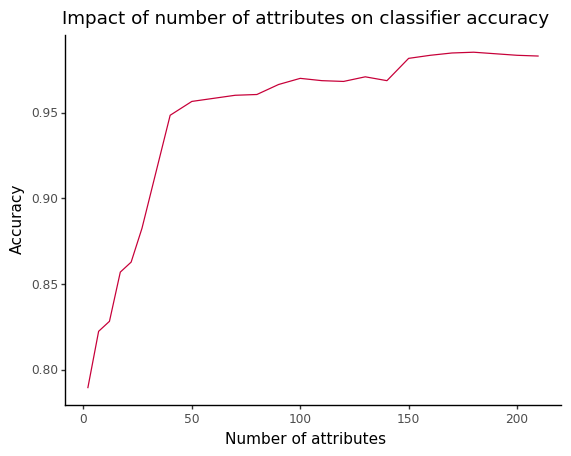

<ggplot: (8736724790493)>

In [14]:
features_to_accuracy = results

df = pd.DataFrame(data=features_to_accuracy, columns = ['Number of attributes', 'Accuracy']) 

(ggplot(df, aes('Number of attributes', 'Accuracy'))
 + ggtitle("Impact of number of attributes on classifier accuracy")
 + geom_line(colour="#C70039")
 + theme_classic())

The figure above shows that the gain of accuracy above 50 features increases in a slow manner. It may be caused by a strong correlation between some features. For instance mean may be very informative as well as median of the same time window but knowing both of them is not more informative that knowing only one.  <br>
To proceed the reduction of dimensions we compute perumtation importance for our baseline.

In [17]:
perm = PermutationImportance(clf).fit(X_test, y_test)
imp = list(zip(X_test.columns.tolist(), perm.feature_importances_))
features = []
for feature in imp:
    if feature[1] > 0:
        features.append(feature[0])

We observe that number of attributes has been reduced to only 81 variables! It's very desired as we want to reduce classifier complexity and therefore energy consumption, beacause we will to make the classifier optimized to run in real time on mobile devices. The list of chosen variables looks as follows:

In [ ]:
features = ['fBodyAccJerk-mad()-Z',
            'fBodyAccMag-meanFreq()',
            'tBodyAcc-arCoeff()-X,1',
            'tGravityAcc-entropy()-Y',
            'fBodyGyro-bandsEnergy()-1,16.2',
            'tBodyGyroJerk-iqr()-X',
            'fBodyAcc-kurtosis()-X',
            'fBodyAccJerk-mean()-Z',
            'fBodyAccMag-mean()',
            'fBodyBodyGyroJerkMag-skewness()',
            'tBodyAcc-min()-Z',
            'tBodyGyro-sma()',
            'tBodyGyroJerk-arCoeff()-Z,2',
            'tBodyGyroJerkMag-mad()',
            'tGravityAccMag-arCoeff()1',
            'fBodyAccMag-energy()',
            'fBodyAccJerk-kurtosis()-Z',
            'fBodyAccJerk-skewness()-X',
            'fBodyGyro-mean()-Z',
            'tBodyAcc-max()-Z',
            'tBodyAccJerk-arCoeff()-Z,3',
            'tBodyGyro-arCoeff()-X,4',
            'tBodyGyro-max()-Z',
            'tGravityAcc-mean()-X',
            'tGravityAcc-mean()-Z',
            'fBodyAccJerk-bandsEnergy()-1,16.1',
            'fBodyAccJerk-sma()',
            'fBodyAccMag-entropy()',
            'fBodyBodyGyroJerkMag-sma()',
            'fBodyGyro-entropy()-Y',
            'tBodyGyro-min()-Y',
            'fBodyBodyGyroJerkMag-max()',
            'angle(tBodyGyroMean,gravityMean)',
            'tBodyAccJerk-iqr()-Y',
            'tBodyGyroJerk-correlation()-X,Z',
            'tGravityAcc-arCoeff()-Z,4',
            'tBodyGyroJerk-std()-X',
            'fBodyBodyAccJerkMag-max()',
            'tBodyAcc-sma()',
            'tBodyAccMag-mean()',
            'tBodyGyro-correlation()-X,Y',
            'fBodyAcc-std()-Y',
            'fBodyAccJerk-meanFreq()-X',
            'tBodyGyro-iqr()-Y',
            'tGravityAccMag-arCoeff()4',
            'fBodyBodyAccJerkMag-skewness()',
            'tGravityAcc-min()-Z',
            'fBodyGyro-bandsEnergy()-1,8.2',
            'fBodyAcc-std()-X',
            'tBodyAccMag-energy()',
            'fBodyAcc-bandsEnergy()-9,16',
            'fBodyGyro-kurtosis()-Z',
            'fBodyAccJerk-std()-Z',
            'tBodyAccJerk-min()-Y',
            'tBodyAccMag-mad()',
            'tBodyGyro-mad()-X',
            'fBodyGyro-max()-X',
            'tGravityAcc-arCoeff()-Y,4',
            'tBodyAcc-entropy()-Y',
            'fBodyAcc-bandsEnergy()-1,16',
            'fBodyAccJerk-meanFreq()-Z',
            'tBodyAcc-std()-Z',
            'tGravityAcc-max()-X',
            'tGravityAcc-max()-Z',
            'tBodyGyro-iqr()-Z',
            'fBodyAcc-max()-Y',
            'fBodyAcc-sma()',
            'fBodyAccJerk-bandsEnergy()-1,8',
            'fBodyGyro-skewness()-Z',
            'fBodyAccMag-mad()',
            'fBodyGyro-mad()-X',
            'tGravityAcc-energy()-Y',
            'tGravityAcc-arCoeff()-Z,3',
            'tBodyAcc-max()-X',
            'tBodyAccJerk-max()-Z',
            'tBodyAccJerk-entropy()-X',
            'fBodyGyro-maxInds-Z',
            'fBodyAccMag-std()',
            'tBodyGyro-iqr()-X',
            'tBodyGyro-max()-X',
            'tGravityAcc-mean()-Y']

# Building classifier
After data cleaning and dimensionality reduction we choose model. We choose the one which achieves, without hyper parametrization, the best mean accuracy in k-fold cross validation. <br>
For each learning strategy we divide dataset into 10 equal parts. Then the model is learned 10 times, each time using 9 different parts of the data. Remaining part is used to evaluate the classifier accuracy: $acc = \frac{C_{+}}{C_{+} + C_{-}}$, where $C_{+}$ is number of correct classifications and $C_{-}$ is number of incorrect classifications. At the end we compute mean accuracy for all 10 iterations, for each model $m$: $\bar{acc}_{m} = \frac{1}{10} \sum_{i=1}^{10}acc_{i}$. All models are trained and evaluated on the same seed.
<br><br>
**Mean accuracy for k-fold cross validation (with k=10):**
<br>
XGBoost:
- `XGBClassifier`:
    - `exact` - 0.9871061134514049
    - `approx` - 0.9881153337057672
    - `gpu_hist` - 0.9868822756715133
    - `hist` - 0.987667029034742
- `XGBRFClassifier`:
    - `exact` - 0.9557119526103083
    - `approx` - 0.9561600056368367
    - `gpu_hist` - 0.9328399842973834
    - `hist` - 0.9551505337379776

CatBoost
 - `CatBoostClassifier` - 0.9880031002602007

scikit-learn:
- `RandomForestClassifier` - 0.9790336096389908
- `LogisticRegression` - 0.9473031259279392
- `ExtraTreeClassifier` - 0.9080621863880458
- `DecisionTreeClassifier` - 0.9414734036931348
- `BernoulliNB` - 0.7154376349443614
- `GradientBoostingClassifier` - 0.9807156014555117

We choose `XGBClassifier`. This model has gained the highest accuracy. The model stands out from other with high accuracy with the term of speed and the fact that XGBoosted classifiers are punished not only for wrong results but also for complexity. Another important characteristic of this classifier is it's explainability - it's possible to print it out in a form understandable to humans (as opposed to random forests or deep neural networks). It's worth noting that this model builds tree with max depth 5. It means that it is possible to predict the class asking only 5 questions. This makes our model not only understandable but also usable by humans.
<br><br>
We parametrize our model using the following values:
```python
tree_method='approx'
```


In [15]:
clf = xgboost.XGBClassifier(tree_method='approx', verbosity=0).fit(X_train, y_train)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


# Results

In [16]:
y_pred = clf.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_pred, labels=['SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']))

,0,1,2,3,4
0,500,17,0,0,0
1,10,479,0,0,0
2,0,0,451,2,0
3,0,0,5,330,2
4,0,0,2,1,431


The data visible in confusion matrix above shows that our model sometimes predicts wrong values for the following activities:
* seating and standing - in both activities person is not moving and body is in vertical position. It is possible to differentiate between standing and seating using gyroscope data describing rotation around Y-axis.
* walking and walking upstairs - in most cases acceleration in Y-axis is enough to differentiate between these activities but sometimes there may be some wrong predictions caused by uneven ground.
* walking upstairs and walking downstairs - the main differences between these activities are velocity of execution and acceleration in Y-axis and different gyroscope values. It's difficult to determine why these activites were confused. The data may be a bit noisy or some entries were recorded in ambigous situations - like changing direction of movement.

To interpret results we use SHAP. It allows to create visualiations showing which variables are the most important for trained classifier.

In [21]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)

We visualize feature importance for all classes.

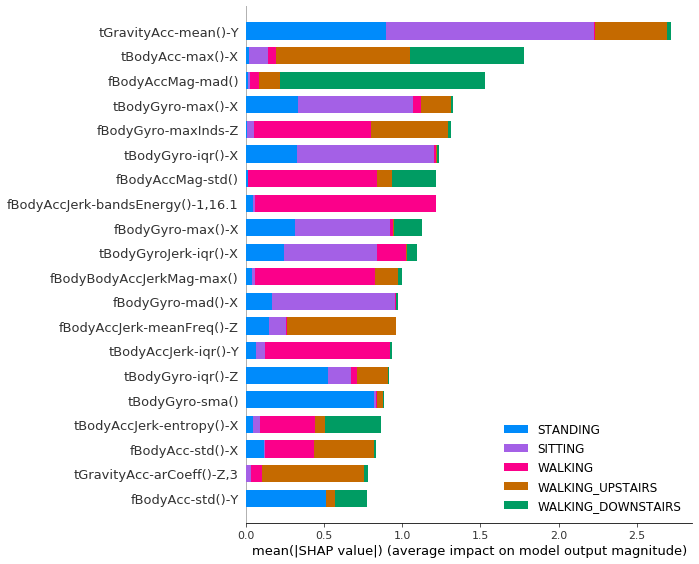

In [22]:
shap.summary_plot(shap_values, X_test, class_names=model.classes_)

We can observe that the most important features are tGravityAcc-mean()-Y (for standing and seating) and tBodyAcc-max()-X (for walking up- and downstairs). We build a more precise analysis for each activity.

## Laying
Class `LAYING` is determined using only `angle(X,gravityMean)` by checking if the value is greater than -1.553 (the phone is "laying"), thus it is determined using simple condition, before applying classifier. Because of that our model is less complex, therefore it will require less power to run. This is very desired as the classifier may run in real time on mobile device.

## Sitting
Most of all, class `SITTING` depends on:
* interquartile of transformed signal of X-axis from gyroscope
* maximum value of signal of Y-axis from X-axis
* mean value of linear acceleration on Y axis

Importance of the X-axis signals gathered using gyroscope may be interpreted as "rotating" in place. Similar conclusions may be drawn from Y-axis accelerometer readings. Moves on this axis may suggest some moves in place, for example altering position while sitting.

<div><img title='sitting' src='../images/sitting.png'></div>

## Standing

Most of all, class `STANDING` depends on:
* simple moving average after signal applying FFT
* interquartile of transformed signal of Y-axis from gyroscope
* mean value of linear acceleration on Y axis

For standing activity the most important variables are correlated with Y-axis, for both sensors - accelerometer and gyroscope. Confusion matrix above ([see here](#Results)) shows that most frequent confusions take place between sitting and standing. The most significant observed difference indicates that while standing person less frequently lean-forward and -backward and has more freedom while rotating.

<div><img title='standing' src='../images/standing.png'></div>

## Walking

Most of all, class `WALKING` depends on:
* jerk measured by acclerometer
* maximum euclidean value of jerk modified by FFT
* changes of values on Y-axis

Therefore we derive the fact that important are movement recorded by accelerometer and swinging on Z-axis.

<div><img title='walking' src='../images/walking.png'></div>

## Walking downstairs

Class `WALKING DOWNSTAIRS` may be derived by observing downward motion by accelerometer on X-axis. We focus on person velocity. It is the most rapid activities in the whole domain as a conseqence of making use of Earth acceleration.

<div><img title='walking downstairs' src='../images/walking_downstairs.png'></div>

## Walking upstairs

Class `WALKING DOWNSTAIRS` depends on maximum value of acceleration on X-axis transformed by FFT. This derive information when person is moving upward. Changes on Z-axis are also important as walking upstairs may be described as rapid, a bit jerky and non-uniform forward motion.

<div><img title='walking upstairs'src='../images/walking_upstairs.png'></div>

# Buisness applications

This classifier may be usefull in the following applications:
* Smart Home
    * Automation of the process of planning changes like opening blinds in the morning.
    * Turning of lights on the ground floor when all inhabitants are upstairs - there was no `WALKING DOWNSTAIRS` state observed after last `WALKING UPSTAIRS`.
* Monitoring physical activites
    * Notifications like "Move on!" when the person stay in static state for a long time.
    * Waking up person if she or he fall asleep while driving a car or on keybord during hackathon.
* Monitoring elder people - detection of rapid changes of states which may suggest danger.

# Bibliography


1. [Energy Efficient Smartphone-Based Activity Recognition using Fixed-Point Arithmetic D. Anguita, A. Ghio, L. Oneto, X. Parra, Jorge Luis Reyes-Ortiz 2013](https://www.semanticscholar.org/paper/Energy-Efficient-Smartphone-Based-Activity-using-Anguita-Ghio/ed2cd4d99795a83a429d733e5cae5fab2dfb868f)       
1. [Human Activity Recognition Using Smartphones Dataset](http://rstudio-pubs-static.s3.amazonaws.com/24009_c068b79c74ae4fec8913fc0bf7a8b451.html)     
1. [Human Activity Recognition with Smartphones - Recordings of 30 study participants performing activities of daily living](https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones)     
1. [XGBoost documentation](https://xgboost.readthedocs.io/en/latest/treemethod.html)  
1. [SHAP documentation](https://github.com/slundberg/shap)